<a href="https://colab.research.google.com/github/sgcortes/25ForageYieldNWSpain/blob/main/V8_BoostrappingRFR_LGBM_XGB_OPTUNA_SHAP_PERMU_kgDM_RAD_Dia_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Regression Models Comparation (LightGBM, XGBoost. Adaboost, Random Forest Regressor. Hyperparameter Tuning with Optuna on best models)

Training and evaluation of 4 basic regression models and additional Hyperparameter optimization with Optuna for LightGBM,XGBoost and RFR.
The last one does not improve metrics with respect to the basic model.

 + LightGBM and XGBoost use categorical variables natively (no codification),
 + Random Forest Regressor and AdaBoost use onehot encoder.
 + No normalization on variable values (e.g. no standarization. This is not needed with ensemble models based on decision trees)
 + Radiation diary mean values (no acumulated radiation values during all the growing season).


In [ ]:
!pip install lightgbm==4.6.0

In [ ]:
# 🔧 Instalación de librerías necesarias
try:
    import optuna
    import lightgbm
    import xgboost
    import shap
    import openpyxl
    import joblib
except ImportError:
    !pip install -q optuna lightgbm xgboost shap scikit-learn openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.7 MB/s eta 0:00:00


In [ ]:
# 📦 Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
import optuna
import shap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [ ]:
# 📂 Cargar datos
file_path = '/content/260324_ENG_MaizeForageSpainNWwtYearRadDay.xlsx'
df = pd.read_excel(file_path)

In [ ]:
# 🎯 Selección de variable objetivo
print("Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']")
objective_var = input("Introduce la variable objetivo para la regresión: ")
assert objective_var in ['kgDM/ha', 'kgCP/ha', 'UFL/ha'], "Variable no válida."

Variables disponibles: ['kgDM/ha', 'kgCP/ha', 'UFL/ha']
Introduce la variable objetivo para la regresión: kgDM/ha


In [ ]:
# Variables
categorical_features = ['Site', 'Cultivar']


y = df[objective_var]
X = df.drop(columns=['kgDM/ha', 'kgCP/ha', 'UFL/ha'])
# Convertir las columnas categóricas a 'category'
for col in categorical_features:
    X[col] = X[col].astype('category')

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##
print(X.columns,"\n")
#print(X.head)

Index(['Site', 'Cultivar', 'Elevation(m)', 'Radiation(Mj/m2day)',
       'Precipitation(mm)', 'Tmax(ºC)', 'Tmin(ºC)', 'WHC(mm)', 'C(%)', 'pH',
       'SowingDate(doy)', 'AnthesisDate(doy)', 'HarvestDate(doy)',
       'GrowingSeason(day)'],
      dtype='object') 



# 🔵 Basic Model  Training (no hyperparameter optimization). LightGBM, XGBoost, Adaboost and Random Forest Regressors.  

In [ ]:
# LightGBM básico
lgb_basic = lgb.LGBMRegressor(categorical_feature=categorical_features)
lgb_basic.fit(X_train, y_train)
y_pred_lgb_basic = lgb_basic.predict(X_test)

# XGBoost básico
xgb_basic = xgb.XGBRegressor(enable_categorical=True, tree_method='hist')
xgb_basic.fit(X_train, y_train)
y_pred_xgb_basic = xgb_basic.predict(X_test)

# One-hot encoding para AdaBoost y Random Forest
X_encoded = pd.get_dummies(X, columns=categorical_features)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# 🔸 AdaBoost Regressor (modelo base: DecisionTree)
adaboost_model = AdaBoostRegressor(random_state=42)
adaboost_model.fit(X_train_enc, y_train_enc)
y_pred_adaboost = adaboost_model.predict(X_test_enc)

# 🔸 Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_enc, y_train_enc)
y_pred_rf = rf_model.predict(X_test_enc)

[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17457.263158


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


# 📈 Basic Models Evaluation

In [ ]:
def evaluate(y_true, y_pred, name="Modelo"):
    print(f"\n{name}")
    print("R2:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("MAPE:", np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

evaluate(y_test, y_pred_lgb_basic, name="LightGBM Basic")
evaluate(y_test, y_pred_xgb_basic, name="XGBoost Basic")
evaluate(y_test, y_pred_adaboost, name="AdaBoost Basic")
evaluate(y_test, y_pred_rf, name="Random Forest Basic")


LightGBM Basic
R2: 0.85913791768533
RMSE: 1232.4424416512527
MAE: 924.8192133075349
MAPE: 5.341202917102477

XGBoost Basic
R2: 0.8334429860115051
RMSE: 1340.1427629174439
MAE: 1008.3441772460938
MAPE: 5.787737034581551

AdaBoost Basic
R2: 0.7615954764368469
RMSE: 1603.3444744795122
MAE: 1217.2303089471502
MAPE: 7.140365786825331

Random Forest Basic
R2: 0.8502983418663235
RMSE: 1270.524075457949
MAE: 968.5524482758622
MAPE: 5.542159958422331


### Variable importance for RMS global reduction

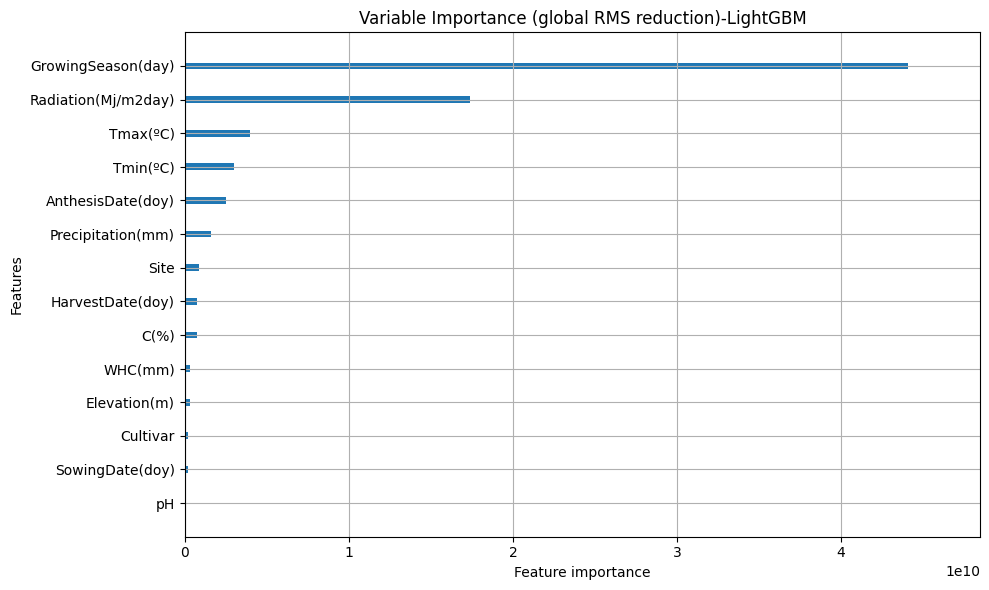

In [ ]:
# Asumiendo que lgb_model ya está entrenado
booster = lgb_basic.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title("Variable Importance (global RMS reduction)-LightGBM")
plt.tight_layout()
plt.show()

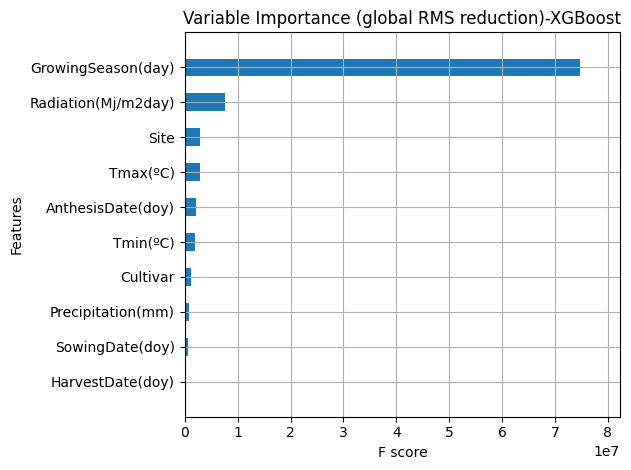

In [ ]:
xgb.plot_importance(
    xgb_basic,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost')
plt.tight_layout()
plt.show()

### Variable importance for RMS reduction with Adaboost and Random Forest Regressor

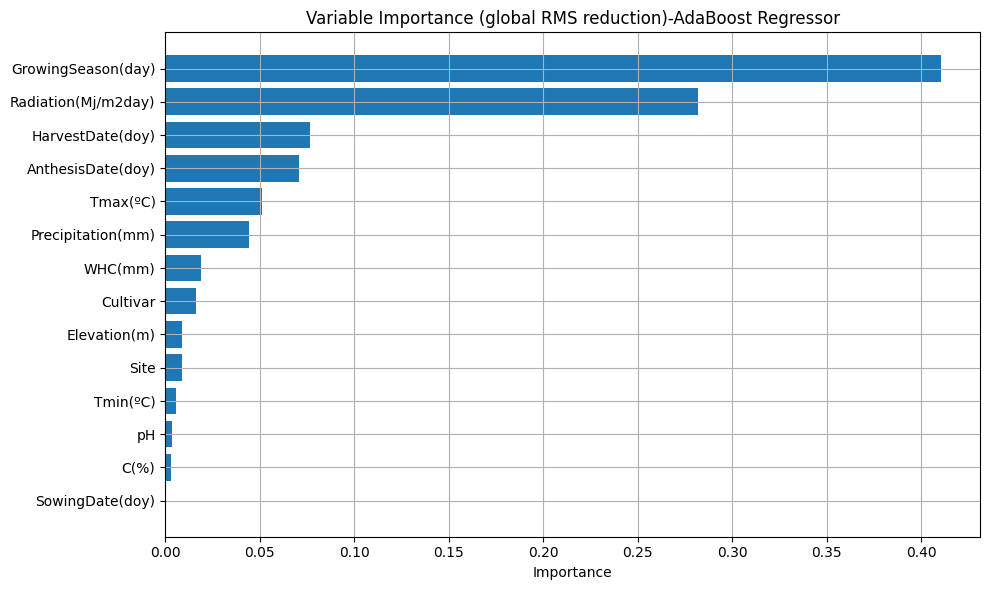

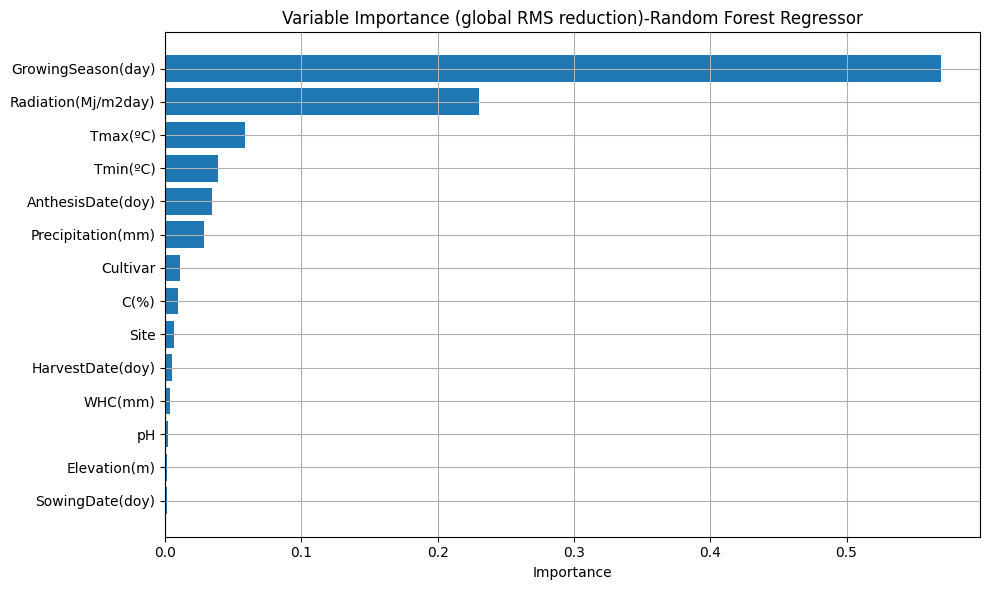

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Obtener nombres de las características
feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f'Feature_{i}' for i in range(X_train_enc.shape[1])]

def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Agrupar variables por prefijo (antes del "_") o quedarse con el nombre si no hay "_"
    def agrupar_nombre(col):
        if '_' in col:
            return col.split('_')[0]  # e.g., Cultivar_200 → Cultivar
        else:
            return col

    importance_df['grupo'] = importance_df['feature'].apply(agrupar_nombre)
    grouped = importance_df.groupby('grupo', as_index=False)['importance'].sum()

    # Orden descendente por importancia
    grouped_sorted = grouped.sort_values(by='importance', ascending=True)

    return grouped_sorted

def plot_feature_importances_grouped(importances, model_name):
    grouped_df = agrupar_importancias(importances, feature_names)

    plt.figure(figsize=(10, 6))
    plt.barh(grouped_df['grupo'], grouped_df['importance'])
    plt.xlabel('Importance')
    plt.title(f'Variable Importance (global RMS reduction)-{model_name}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 🔹 AdaBoost
plot_feature_importances_grouped(adaboost_model.feature_importances_, 'AdaBoost Regressor')

# 🔸 Random Forest
plot_feature_importances_grouped(rf_model.feature_importances_, 'Random Forest Regressor')


# 🧪 Hyperparameter Optimization with Optuna

In [ ]:
def objective_lgb(trial):
    params = {
        'objective': 'regression',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'random_state': 42
    }
    model = lgb.LGBMRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_xgb(trial):
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'tree_method': 'hist',
        'enable_categorical': True,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    score = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
    return -score

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestRegressor(**params)
    score = cross_val_score(model, X_train_enc, y_train_enc, cv=5, scoring='r2', n_jobs=-1).mean()
    return score


study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=30)

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=30)

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=30)


[I 2025-05-08 16:43:42,349] A new study created in memory with name: no-name-51fc0931-1d1e-4784-b44f-5afe5805b34b


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:42,700] Trial 0 finished with value: 1315.0072281653615 and parameters: {'learning_rate': 0.14404920937656723, 'num_leaves': 103, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.5337444965181222, 'colsample_bytree': 0.7945808382151609}. Best is trial 0 with value: 1315.0072281653615.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:43,112] Trial 1 finished with value: 1291.3302761063178 and parameters: {'learning_rate': 0.21802442132225122, 'num_leaves': 126, 'max_depth': 14, 'min_child_samples': 39, 'subsample': 0.6260345378566117, 'colsample_bytree': 0.7656370915810258}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:43,359] Trial 2 finished with value: 1362.7359222244463 and parameters: {'learning_rate': 0.27877878089577035, 'num_leaves': 128, 'max_depth': 3, 'min_child_samples': 96, 'subsample': 0.9541060715700527, 'colsample_bytree': 0.7175472086956571}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:43,660] Trial 3 finished with value: 1313.4466965856736 and parameters: {'learning_rate': 0.1606909824843371, 'num_leaves': 151, 'max_depth': 4, 'min_child_samples': 56, 'subsample': 0.5992816433572139, 'colsample_bytree': 0.993306579672772}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:43,995] Trial 4 finished with value: 1560.9260265854134 and parameters: {'learning_rate': 0.01568887285422589, 'num_leaves': 27, 'max_depth': 14, 'min_child_samples': 15, 'subsample': 0.6510914074611881, 'colsample_bytree': 0.899626020280921}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17465.486516
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

[I 2025-05-08 16:43:44,168] Trial 5 finished with value: 1369.1725054593207 and parameters: {'learning_rate': 0.1406177846978538, 'num_leaves': 153, 'max_depth': 11, 'min_child_samples': 96, 'subsample': 0.9654759797813397, 'colsample_bytree': 0.5562041480799491}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:44,421] Trial 6 finished with value: 1317.1131956531615 and parameters: {'learning_rate': 0.2726534648470656, 'num_leaves': 190, 'max_depth': 14, 'min_child_samples': 44, 'subsample': 0.8672178458581353, 'colsample_bytree': 0.6801021307530415}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:44,729] Trial 7 finished with value: 1312.390978048757 and parameters: {'learning_rate': 0.2857532336310637, 'num_leaves': 111, 'max_depth': 15, 'min_child_samples': 36, 'subsample': 0.6605120886010118, 'colsample_bytree': 0.941033325860479}. Best is trial 1 with value: 1291.3302761063178.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:45,039] Trial 8 finished with value: 1288.916416542817 and parameters: {'learning_rate': 0.26040389998536667, 'num_leaves': 43, 'max_depth': 15, 'min_child_samples': 22, 'subsample': 0.8396915461771269, 'colsample_bytree': 0.5192936798566108}. Best is trial 8 with value: 1288.916416542817.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:45,244] Trial 9 finished with value: 1341.8085965458154 and parameters: {'learning_rate': 0.16978961097092626, 'num_leaves': 55, 'max_depth': 12, 'min_child_samples': 84, 'subsample': 0.8493996824110914, 'colsample_bytree': 0.8670977365128937}. Best is trial 8 with value: 1288.916416542817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17465.486516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:45,636] Trial 10 finished with value: 1234.348567863601 and parameters: {'learning_rate': 0.06400621844004012, 'num_leaves': 68, 'max_depth': 7, 'min_child_samples': 7, 'subsample': 0.7788197911863824, 'colsample_bytree': 0.5059579895340475}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:46,017] Trial 11 finished with value: 1250.203111327862 and parameters: {'learning_rate': 0.050582432128677274, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 5, 'subsample': 0.7695225429440331, 'colsample_bytree': 0.5118701777825037}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:46,367] Trial 12 finished with value: 1252.1376925824866 and parameters: {'learning_rate': 0.044358959076671686, 'num_leaves': 69, 'max_depth': 6, 'min_child_samples': 8, 'subsample': 0.7541725210060379, 'colsample_bytree': 0.6103534262451665}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:46,776] Trial 13 finished with value: 1242.485630240693 and parameters: {'learning_rate': 0.08172285481316194, 'num_leaves': 75, 'max_depth': 7, 'min_child_samples': 6, 'subsample': 0.7602431371854399, 'colsample_bytree': 0.6194646677900273}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17465.486516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:47,092] Trial 14 finished with value: 1235.9802283904967 and parameters: {'learning_rate': 0.09277986045006215, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 26, 'subsample': 0.7241941102387541, 'colsample_bytree': 0.6230158092022242}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:47,404] Trial 15 finished with value: 1236.3028038876437 and parameters: {'learning_rate': 0.09289759706595344, 'num_leaves': 91, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.7012245954352159, 'colsample_bytree': 0.5995617751619344}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:47,644] Trial 16 finished with value: 1319.1953500226196 and parameters: {'learning_rate': 0.1019553739733054, 'num_leaves': 22, 'max_depth': 8, 'min_child_samples': 64, 'subsample': 0.8172759422482011, 'colsample_bytree': 0.6684695614310122}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-08 16:43:47,904] Trial 17 finished with value: 1254.0964814607892 and parameters: {'learning_rate': 0.1110347465140727, 'num_leaves': 87, 'max_depth': 5, 'min_child_samples': 26, 'subsample': 0.9109917279315238, 'colsample_bytree': 0.5618468208178772}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:48,262] Trial 18 finished with value: 1242.784171379451 and parameters: {'learning_rate': 0.059801762775806525, 'num_leaves': 46, 'max_depth': 9, 'min_child_samples': 18, 'subsample': 0.705084686427891, 'colsample_bytree': 0.6700240368061309}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:48,556] Trial 19 finished with value: 1592.2894963503154 and parameters: {'learning_rate': 0.017545649821523054, 'num_leaves': 115, 'max_depth': 9, 'min_child_samples': 31, 'subsample': 0.5686965442899736, 'colsample_bytree': 0.5053262563091371}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:48,791] Trial 20 finished with value: 1319.28083479637 and parameters: {'learning_rate': 0.2018362747051687, 'num_leaves': 146, 'max_depth': 7, 'min_child_samples': 65, 'subsample': 0.7013567826313427, 'colsample_bytree': 0.574074004565743}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-05-08 16:43:49,199] Trial 21 finished with value: 1236.2613243785736 and parameters: {'learning_rate': 0.09089652585079333, 'num_leaves': 93, 'max_depth': 11, 'min_child_samples': 15, 'subsample': 0.7079497780267292, 'colsample_bytree': 0.6067299101144338}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17465.486516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:49,606] Trial 22 finished with value: 1235.376529885303 and parameters: {'learning_rate': 0.12302221568652291, 'num_leaves': 95, 'max_depth': 12, 'min_child_samples': 15, 'subsample': 0.7999159391812212, 'colsample_bytree': 0.6391704705992726}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:50,043] Trial 23 finished with value: 1241.9637944004003 and parameters: {'learning_rate': 0.1276691461758935, 'num_leaves': 60, 'max_depth': 12, 'min_child_samples': 14, 'subsample': 0.7895913135803466, 'colsample_bytree': 0.7217054982037096}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Start training from score 17465.486516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[I 2025-05-08 16:43:50,373] Trial 24 finished with value: 1239.488560505245 and parameters: {'learning_rate': 0.06582553149388062, 'num_leaves': 83, 'max_depth': 10, 'min_child_samples': 28, 'subsample': 0.892274157916991, 'colsample_bytree': 0.6407371339755208}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:50,733] Trial 25 finished with value: 1247.8365470235879 and parameters: {'learning_rate': 0.12413812801285878, 'num_leaves': 102, 'max_depth': 8, 'min_child_samples': 13, 'subsample': 0.806994767539191, 'colsample_bytree': 0.8257551157693618}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 649
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17421.316073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:50,996] Trial 26 finished with value: 1285.675112036617 and parameters: {'learning_rate': 0.17490541544298766, 'num_leaves': 128, 'max_depth': 6, 'min_child_samples': 45, 'subsample': 0.729288423763442, 'colsample_bytree': 0.7118798182527657}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 927, number of used features: 14
[LightGBM] [Info] Start training from score 17508.599784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:51,314] Trial 27 finished with value: 1291.5735605118084 and parameters: {'learning_rate': 0.03939908412868398, 'num_leaves': 198, 'max_depth': 12, 'min_child_samples': 34, 'subsample': 0.91465258966176, 'colsample_bytree': 0.5435197643425778}. Best is trial 10 with value: 1234.348567863601.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 653
[LightGBM] [Info] Number of data points in the train set: 928, number of used features: 14
[LightGBM] [Info] Start training from score 17439.394397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-05-08 16:43:52,294] Trial 28 finished with value: 1232.5144288488523 and parameters: {'learning_rate': 0.07551643564120311, 'num_leaves': 42, 'max_depth': 9, 'min_child_samples': 22, 'subsample': 0.6620908970156192, 'colsample_bytree': 0.6387425631892538}. Best is trial 28 with value: 1232.5144288488523.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:52,944] Trial 29 finished with value: 1243.8787756544418 and parameters: {'learning_rate': 0.07060506516171111, 'num_leaves': 38, 'max_depth': 10, 'min_child_samples': 20, 'subsample': 0.6701328911221561, 'colsample_bytree': 0.767221107915798}. Best is trial 28 with value: 1232.5144288488523.
[I 2025-05-08 16:43:52,956] A new study created in memory with name: no-name-56a93798-3dd3-4cb3-bf17-62281630127e


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-08 16:43:56,262] Trial 0 finished with value: 1261.462646484375 and parameters: {'learning_rate': 0.20208783471084799, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6566270746778149, 'colsample_bytree': 0.7279514810271479}. Best is trial 0 with value: 1261.462646484375.
[I 2025-05-08 16:43:57,291] Trial 1 finished with value: 1273.8717529296875 and parameters: {'learning_rate': 0.06281685729577492, 'max_depth': 15, 'min_child_weight': 3, 'subsample': 0.5345522200285193, 'colsample_bytree': 0.5344545245012675}. Best is trial 0 with value: 1261.462646484375.
[I 2025-05-08 16:43:58,199] Trial 2 finished with value: 1268.9501953125 and parameters: {'learning_rate': 0.03510598573556676, 'max_depth': 13, 'min_child_weight': 5, 'subsample': 0.5866374630524962, 'colsample_bytree': 0.6438623740173566}. Best is trial 0 with value: 1261.462646484375.
[I 2025-05-08 16:43:59,283] Trial 3 finished with value: 1286.84521484375 and parameters: {'learning_rate': 0.14091124348324754, 

# 🚀 Regressors Training on Optimized Models

In [ ]:
lgb_best = lgb.LGBMRegressor(**study_lgb.best_params, categorical_feature=categorical_features)
lgb_best.fit(X_train, y_train)
y_pred_lgb_best = lgb_best.predict(X_test)

xgb_best = xgb.XGBRegressor(**study_xgb.best_params, enable_categorical=True, tree_method='hist')
xgb_best.fit(X_train, y_train)
y_pred_xgb_best = xgb_best.predict(X_test)

# Entrenar modelo con mejores hiperparámetros
rf_best = RandomForestRegressor(**study_rf.best_params)
rf_best.fit(X_train_enc, y_train_enc)
y_pred_rf_best = rf_best.predict(X_test_enc)

evaluate(y_test, y_pred_lgb_best, name="LightGBM Optuna")
evaluate(y_test, y_pred_xgb_best, name="XGBoost Optuna")
evaluate(y_test, y_pred_rf_best, name="RFR Optuna")

/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")


[LightGBM] [Warning] categorical_feature is set=Site,Cultivar, categorical_column=0,1 will be ignored. Current value: categorical_feature=Site,Cultivar
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 661
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17457.263158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

### Global Variable importance for Optimized Regressors (XGBoost and LightGBM)

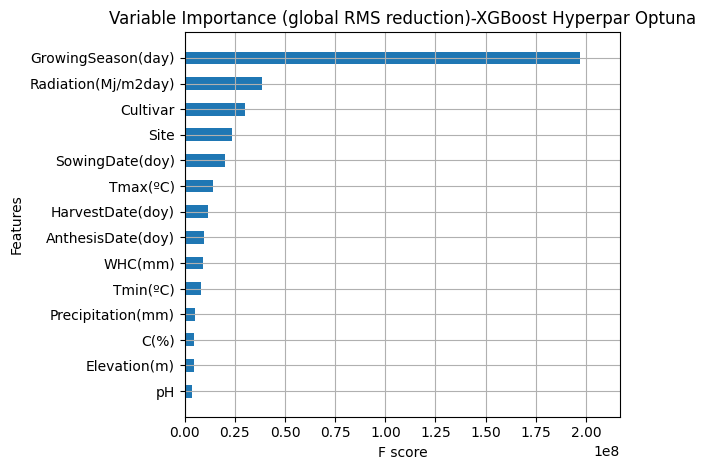

In [ ]:
xgb.plot_importance(
    xgb_best,
    importance_type='gain',   # 'gain' mide cuánto mejora la predicción una variable (puedes usar 'weight' o 'cover' también)
    max_num_features=20,      # mostrar solo las 15 más importantes
    height=0.5,               # altura de las barras
    show_values=False         # si quieres que no ponga los números al lado
)

plt.title('Variable Importance (global RMS reduction)-XGBoost Hyperpar Optuna')
plt.tight_layout()
plt.show()

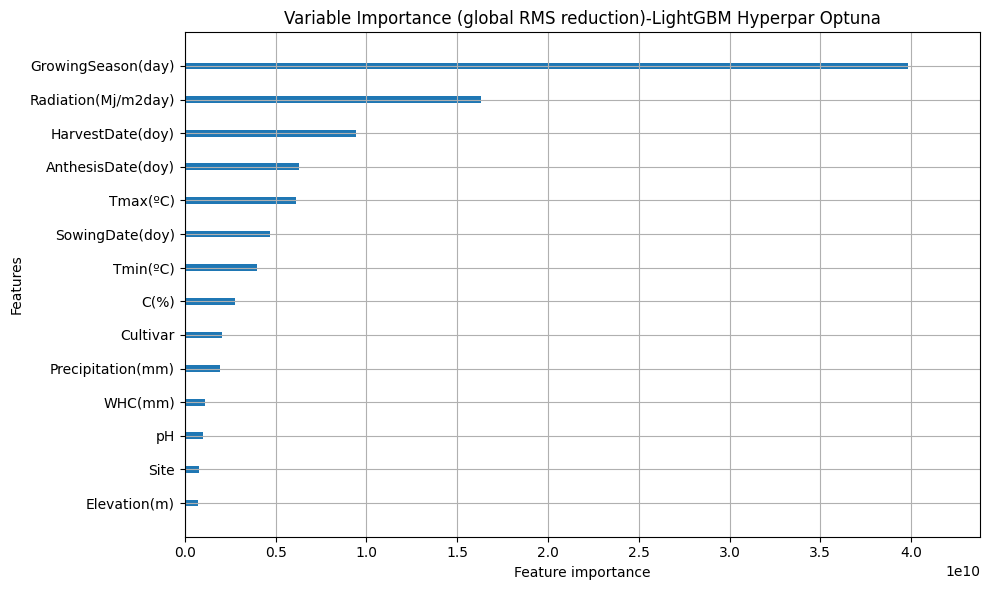

In [ ]:
booster = lgb_best.booster_  # Extrae el booster del modelo sklearn

ax = lgb.plot_importance(booster, max_num_features=15, importance_type='gain', figsize=(10, 6))
# Eliminar los valores numéricos que aparecen en las barras
for text in ax.texts:
    text.set_visible(False)
plt.title('Variable Importance (global RMS reduction)-LightGBM Hyperpar Optuna')
plt.tight_layout()
plt.show()

### Variable permutation  Tests

📊 Test de Permutación - LightGBM Optuna


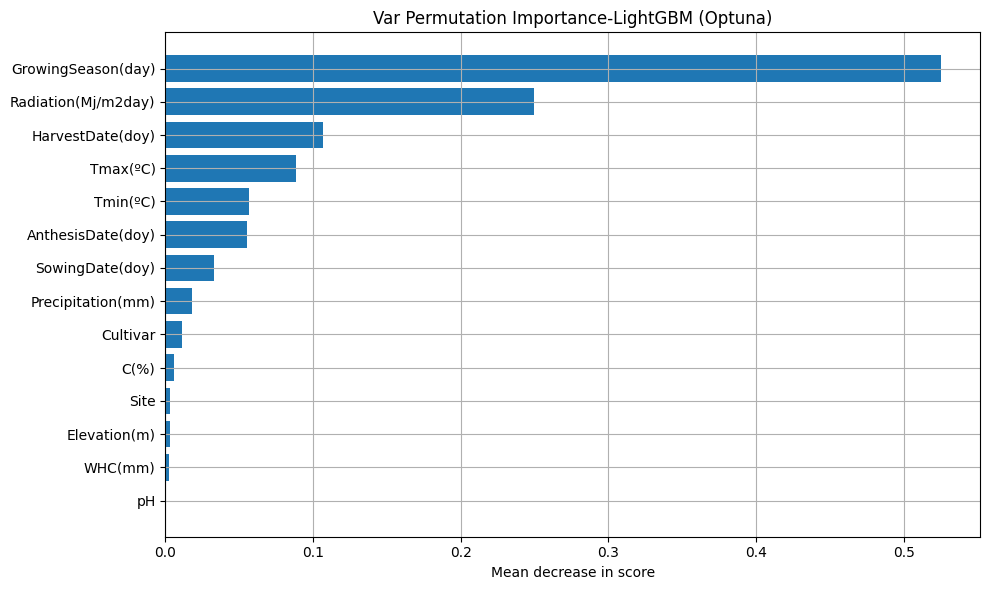

Var Permutation Importance-XGBoost (Optuna)


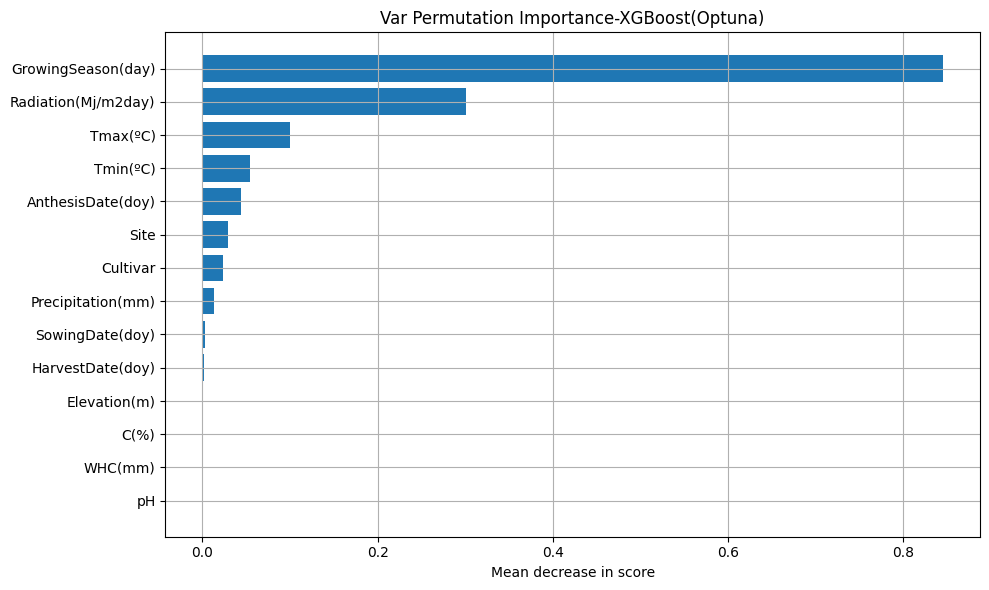

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Test de permutación para LightGBM optimizado
print("📊 Test de Permutación - LightGBM Optuna")
perm_lgb = permutation_importance(
    lgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_lgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_lgb.importances_mean[sorted_idx])
plt.title("Var Permutation Importance-LightGBM (Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()

# Test de permutación para XGBoost optimizado
print("Var Permutation Importance-XGBoost (Optuna)")
perm_xgb = permutation_importance(
    xgb_best, X_test, y_test,
    n_repeats=10, random_state=42, n_jobs=-1
)

# Ordenar variables de mayor a menor importancia
sorted_idx = perm_xgb.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_xgb.importances_mean[sorted_idx])
plt.title("Var Permutation Importance-XGBoost(Optuna)")
plt.xlabel("Mean decrease in score")
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


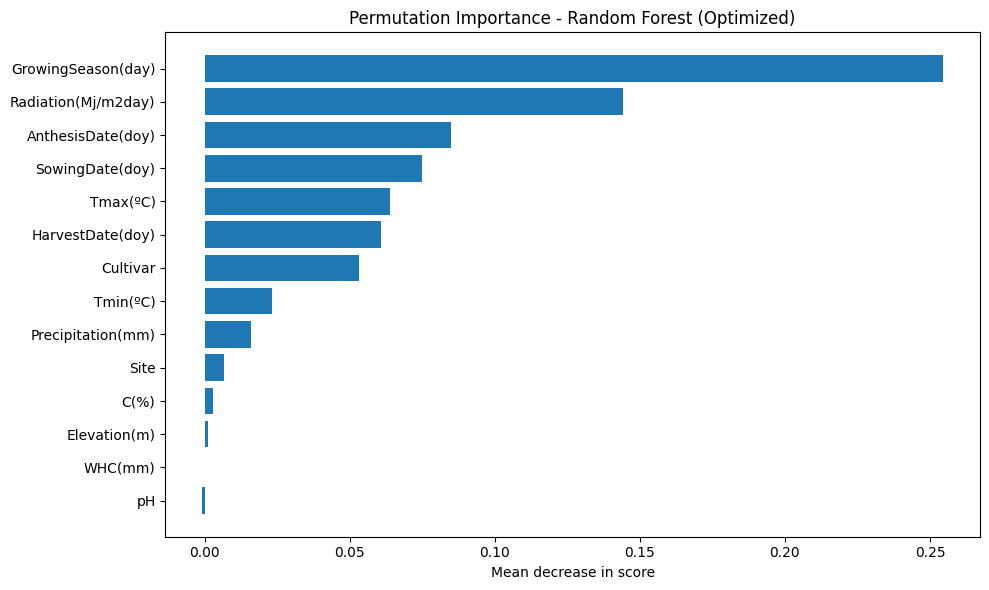

In [ ]:

# 📊 Permutation importance - Random Forest (optimized)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

perm_rf = permutation_importance(rf_best, X_test_enc, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importances_rf = perm_rf.importances_mean

# Agrupar por variable base (si es one-hot)
def agrupar_importancias(importances, feature_names):
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df['grupo'] = importance_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)
    return importance_df.groupby('grupo', as_index=False)['importance'].sum().sort_values(by='importance', ascending=True)

feature_names = X_train_enc.columns if hasattr(X_train_enc, 'columns') else [f"Feature_{i}" for i in range(X_train_enc.shape[1])]
df_rf_perm = agrupar_importancias(importances_rf, feature_names)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(df_rf_perm['grupo'], df_rf_perm['importance'])
plt.title("Permutation Importance - Random Forest (Optimized)")
plt.xlabel("Mean decrease in score")
plt.tight_layout()
plt.show()


### SHAP Values

📌 SHAP Values for Optimized LightGBM



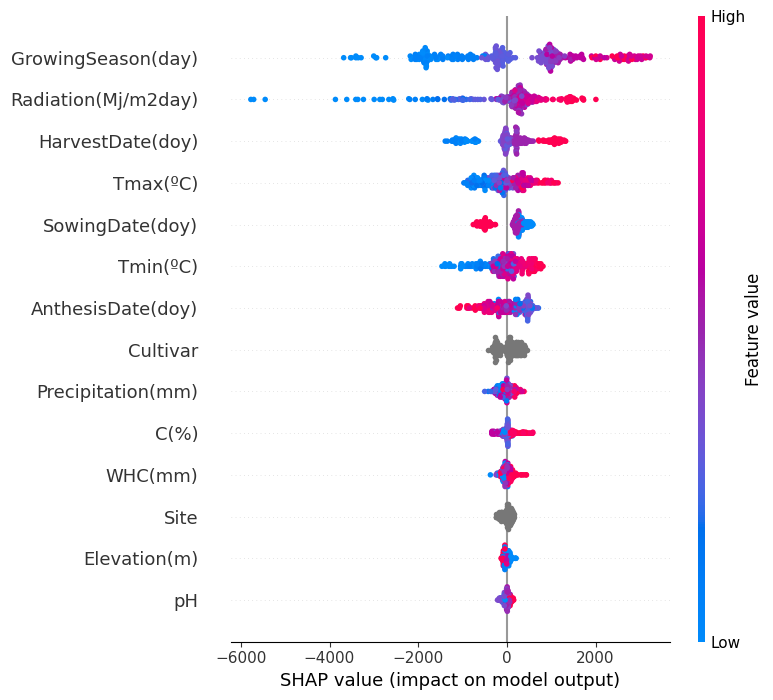

In [ ]:
# 🔍 Calcular y visualizar SHAP values para LightGBM
import shap
shap.initjs()

# TreeExplainer para modelos basados en árboles como LightGBM
explainer_lgb = shap.TreeExplainer(lgb_best)
shap_values_lgb = explainer_lgb.shap_values(X_test)

# Gráfico resumen
shap.summary_plot(shap_values_lgb, X_test)

📌 SHAP for Optmized XGBoost

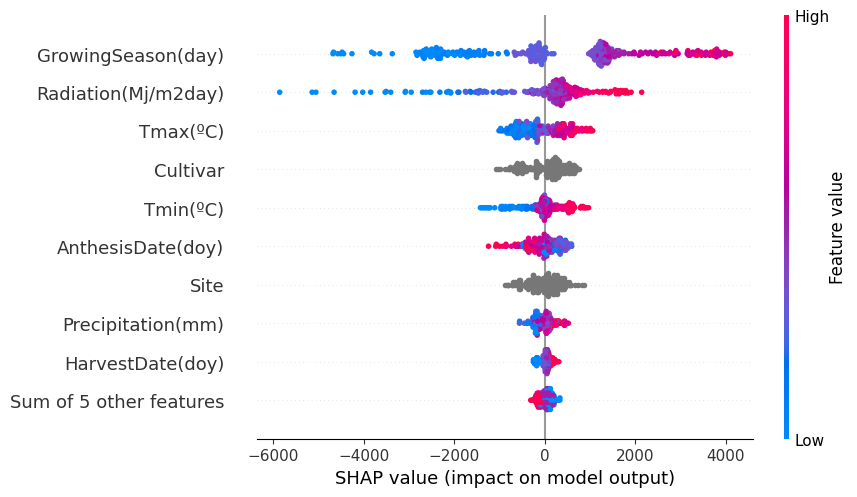

In [ ]:
# 🔍 Calcular y visualizar SHAP values para XGBoost
explainer_xgb = shap.TreeExplainer(xgb_best)
shap_values_xgb = explainer_xgb(X_test)

# Gráfico resumen SHAP
shap.plots.beeswarm(shap_values_xgb)

###  💾 SAVING OPTIMIZED MODELS

In [ ]:
import joblib

joblib.dump(lgb_best, "lgb_best_model.pkl")
joblib.dump(xgb_best, "xgb_best_model.pkl")
joblib.dump(rf_best, "rfr_best_model.pkl")

print("Succesfully exported models.")


Succesfully exported models.


## PREDICTION

In [ ]:
# 📦 Cargar modelos y realizar predicciones con nuevos datos
lgbm_loaded = joblib.load("lgb_best_model.pkl")
xgb_loaded = joblib.load("xgb_best_model.pkl")
rfr_loaded = joblib.load("rfr_best_model.pkl")

# Reemplazar X_nuevos_datos por datos reales
# y_pred_lgb = lgb_loaded.predict(X_nuevos_datos)
# y_pred_xgb = xgb_loaded.predict(X_nuevos_datos)
# y_pred_rfr = rfr_loaded.predict(X_nuevos_datos) # onehto codification needed

## Booststrappint for confidence intervals on LightGBM

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 1159, number of used features: 14
[LightGBM] [Info] Start training from score 17304.125971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

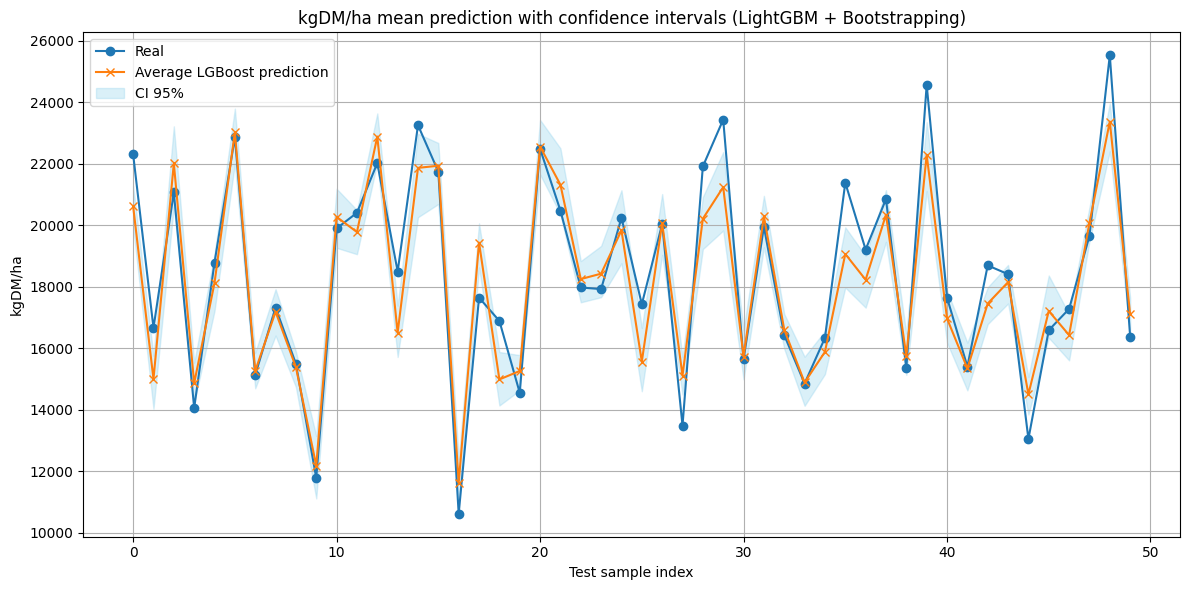

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_squared_error
import lightgbm as lgb

# -------------------------
# Bootstrapping parameters
# -------------------------
n_bootstraps = 100
bootstrap_preds_lgb = []

# -------------------------
# Bootstrapped model training
# -------------------------
for i in range(n_bootstraps):
    # Re-muestreo con reemplazo
    X_resampled, y_resampled = resample(X_train, y_train, random_state=42+i)

    # Entrenamiento con hiperparámetros óptimos
    model_lgb = lgb.LGBMRegressor(**study_lgb.best_params, random_state=42+i)
    model_lgb.fit(X_resampled, y_resampled, categorical_feature=categorical_features)

    # Predicción sobre test
    y_pred = model_lgb.predict(X_test)
    bootstrap_preds_lgb.append(y_pred)

# -------------------------
# Aggregated predictions and confidence intervals
# -------------------------
bootstrap_preds_lgb = np.array(bootstrap_preds_lgb)
y_pred_mean_lgb = bootstrap_preds_lgb.mean(axis=0)
y_pred_lower_lgb = np.percentile(bootstrap_preds_lgb, 2.5, axis=0)
y_pred_upper_lgb = np.percentile(bootstrap_preds_lgb, 97.5, axis=0)

# -------------------------
# Evaluation metrics
# -------------------------
print("📊 R2 LGBoost:", r2_score(y_test, y_pred_mean_lgb))
print("📉 RMSE LGBoost:", np.sqrt(mean_squared_error(y_test, y_pred_mean_lgb)))

# -------------------------
# Visualization
# -------------------------
plt.figure(figsize=(12, 6))
x_range = np.arange(len(y_test[:50]))  # mostrar primeras 50 muestras
plt.plot(x_range, y_test[:50], label='Real', marker='o')
plt.plot(x_range, y_pred_mean_lgb[:50], label='Average LGBoost prediction', marker='x')
plt.fill_between(x_range, y_pred_lower_lgb[:50], y_pred_upper_lgb[:50], color='skyblue', alpha=0.3, label='CI 95%')
plt.title("kgDM/ha mean prediction with confidence intervals (LightGBM + Bootstrapping)")
plt.xlabel("Test sample index")
plt.ylabel("kgDM/ha")
plt.legend()
plt.tight_layout()
plt.grid('on')
plt.show()


### Percentage of test samples in the 95% CI

In [ ]:
# Asegurémonos de que y_test esté en formato array (o Series de pandas)
import numpy as np

# Convertir a array en caso de ser una Series
y_test_array = np.array(y_test)

# Calcular un booleano para cada muestra: True si el valor real está dentro del intervalo, False de lo contrario.
in_interval = (y_test_array >= y_pred_lower_lgb) & (y_test_array <= y_pred_upper_lgb)

# Calcular el porcentaje de muestras que cumplen con la condición
percentage_in_interval = in_interval.mean() * 100

print("Percetange of samples inside the 95% confidence interval: {:.2f}%".format(percentage_in_interval))


Percetange of samples inside the 95% confidence interval: 55.17%
